In [1]:

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/Datafiles/project_1_data.csv"


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv(path)
df = df.rename(columns={
    'Year': 'year',
    'TOTAL FAMILY INCOM': 'family_income',
    'AMT INVESTED IN STOCKS ': 'stocks',
    'AMOUNT CREDIT/STORE CARD DEBT': 'credit_debt',
    ' COMPLETED ED': 'education'
})

In [3]:
df.fillna(0, inplace=True)

In [38]:
# covid grouping
df['period'] = df['year'].apply(lambda y: 'Pre-COVID' if y <= 2019 else 'Post-COVID')

summary = (
    df.groupby('period')[['family_income', 'stocks']]
    .agg(['mean', 'median'])
    .reset_index()
)

summary.columns = ['period', 'income_mean', 'income_median', 'stocks_mean', 'stocks_median']
print(summary)


       period   income_mean  income_median   stocks_mean  stocks_median
0  Post-COVID  65187.723015        37600.0  7.988633e+06            0.0
1   Pre-COVID  58448.338416        38000.0  6.899125e+06            0.0


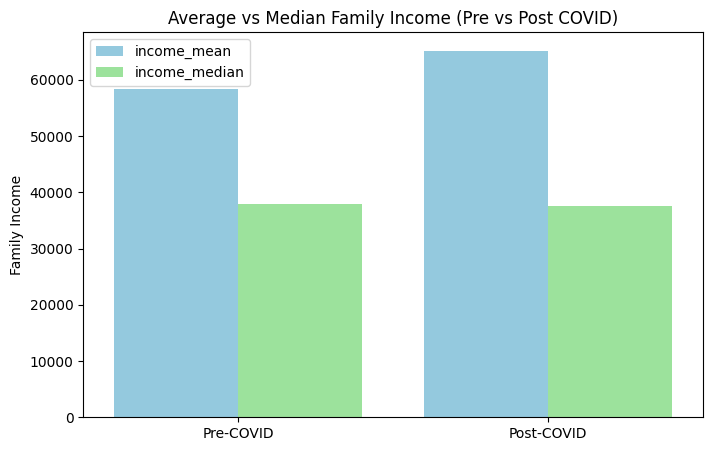

In [40]:
palette = ['skyblue', 'lightgreen']

# avg and median plot
plt.figure(figsize=(8,5))
summary_melt_income = summary.melt(id_vars='period', value_vars=['income_mean','income_median'],
                                   var_name='stat', value_name='value')
sns.barplot(x='period', y='value', hue='stat', data=summary_melt_income, palette=palette, order=['Pre-COVID', 'Post-COVID'])
plt.title("Average vs Median Family Income (Pre vs Post COVID)")
plt.ylabel("Family Income")
plt.xlabel("")
plt.legend(title="")
plt.show()

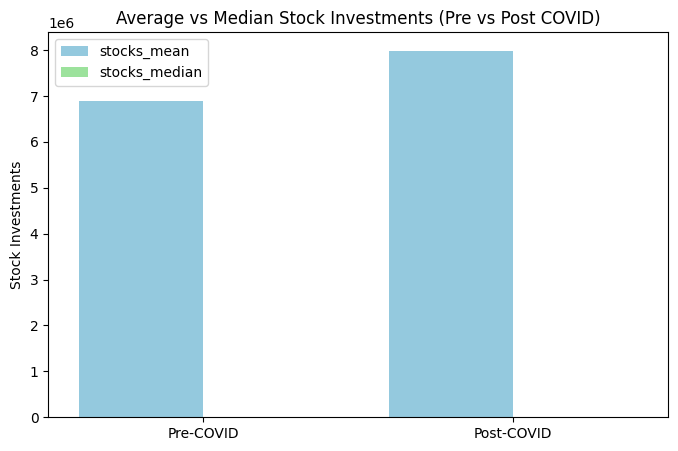

In [42]:
# investment plot
palette = ['skyblue', 'lightgreen']
plt.figure(figsize=(8,5))
summary_melt_stocks = summary.melt(id_vars='period', value_vars=['stocks_mean','stocks_median'],
                                   var_name='stat', value_name='value')
sns.barplot(x='period', y='value', hue='stat', data=summary_melt_stocks, palette=palette,  order=['Pre-COVID', 'Post-COVID'])
plt.title("Average vs Median Stock Investments (Pre vs Post COVID)")
plt.ylabel("Stock Investments")
plt.xlabel("")
plt.legend(title="")
plt.show()

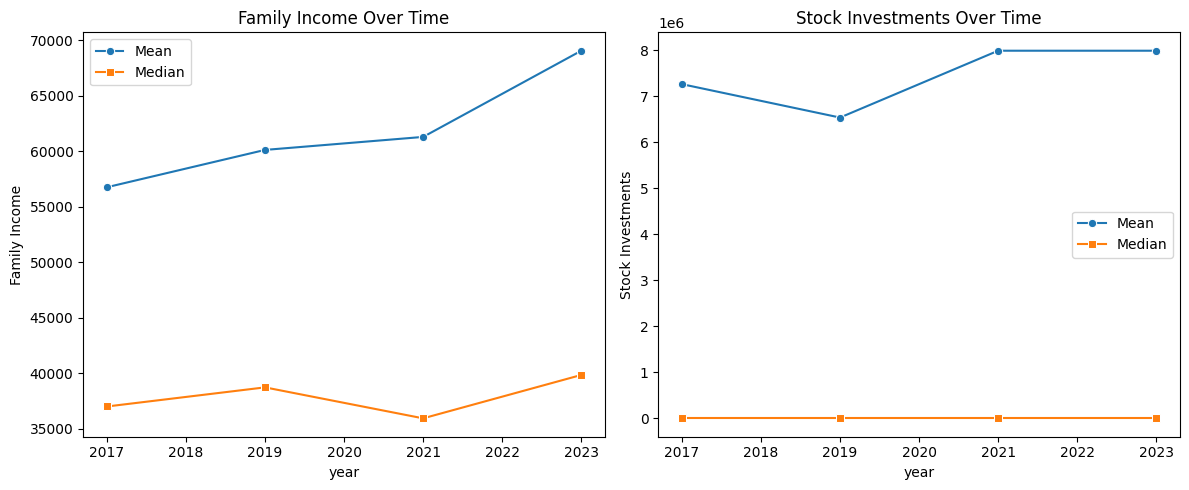

In [43]:
# Line chart by year
yearly = (
    df.groupby('year')[['family_income','stocks']]
    .agg(['mean','median'])
    .reset_index()
)
yearly.columns = ['year','income_mean','income_median','stocks_mean','stocks_median']

fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True)
sns.lineplot(x='year', y='income_mean', data=yearly, ax=ax[0], marker='o', label='Mean')
sns.lineplot(x='year', y='income_median', data=yearly, ax=ax[0], marker='s', label='Median')
ax[0].set_title("Family Income Over Time")
ax[0].set_ylabel("Family Income")

sns.lineplot(x='year', y='stocks_mean', data=yearly, ax=ax[1], marker='o', label='Mean')
sns.lineplot(x='year', y='stocks_median', data=yearly, ax=ax[1], marker='s', label='Median')
ax[1].set_title("Stock Investments Over Time")
ax[1].set_ylabel("Stock Investments")

plt.tight_layout()
plt.show()

In [44]:
df.isnull().sum()

,0
year,0
FAMILY INTERVIEW (ID) NUMBER,0
credit_debt,0
stocks,0
family_income,0
education,0
period,0
net_wealth,0
high_wealth,0


In [45]:
#tp80

df['net_wealth'] = df['family_income'].fillna(0) + df['stocks'].fillna(0) - df['credit_debt'].fillna(0)


tp80 = df['net_wealth'].quantile(0.8)
print(f"Top 20% (TP80) threshold: {tp80:,.2f}")


df['high_wealth'] = (df['net_wealth'] > tp80).astype(int)

print(df['high_wealth'].value_counts(normalize=True))
print(df[['year', 'family_income', 'stocks', 'credit_debt', 'net_wealth', 'high_wealth']].head(10))


Top 20% (TP80) threshold: 98,300.00
high_wealth
0    0.800056
1    0.199944
Name: proportion, dtype: float64
   year  family_income  stocks  credit_debt  net_wealth  high_wealth
0  2017        10800.0     0.0          0.0     10800.0            0
1  2017        56000.0     0.0          0.0     56000.0            0
2  2017         3705.0     0.0          0.0      3705.0            0
3  2017        89347.0     0.0          0.0     89347.0            0
4  2017        23500.0     0.0          0.0     23500.0            0
5  2017        26000.0     0.0          0.0     26000.0            0
6  2017        37207.0     0.0          0.0     37207.0            0
7  2017            0.0     0.0          0.0         0.0            0
8  2017            0.0     0.0          0.0         0.0            0
9  2017        81139.0     0.0          0.0     81139.0            0


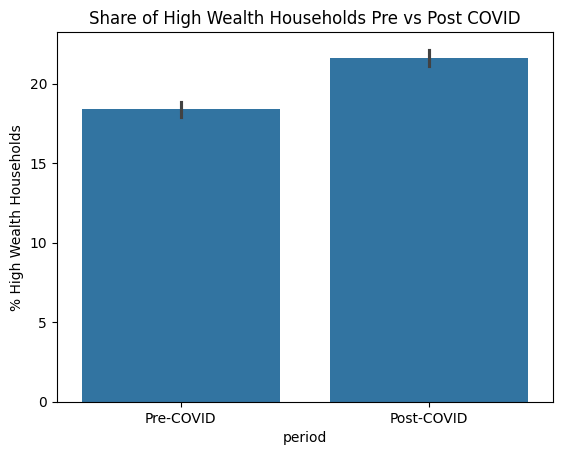

In [47]:
#share wealth plot
import seaborn as sns
import matplotlib.pyplot as plt

df['period'] = df['year'].apply(lambda y: 'Pre-COVID' if y <= 2019 else 'Post-COVID')

sns.barplot(x='period', y='high_wealth', data=df, estimator=lambda x: 100*sum(x)/len(x))
plt.ylabel("% High Wealth Households")
plt.title("Share of High Wealth Households Pre vs Post COVID")
plt.show()


In [48]:
#summary wealth groups

summary = df.groupby('period')['high_wealth'].agg(
    count='count',
    high_wealth_households='sum'
)
summary['pct_high_wealth'] = 100 * summary['high_wealth_households'] / summary['count']

print(summary)


            count  high_wealth_households  pct_high_wealth
period                                                    
Post-COVID  24792                    5355        21.599710
Pre-COVID   24792                    4559        18.388996


In [49]:
#new df and tp80 and tp95 thresholds

df2 = pd.read_csv(path)
df2 = df2.rename(columns={
    'Year': 'year',
    'TOTAL FAMILY INCOM': 'family_income',
    'AMT INVESTED IN STOCKS ': 'stocks',
    'AMOUNT CREDIT/STORE CARD DEBT': 'credit_debt',
    ' COMPLETED ED': 'education'
})
df2.fillna(0, inplace=True)
df2['net_wealth'] = df2['family_income'] + df2['stocks'] - df2['credit_debt']


tp80 = df2['net_wealth'].quantile(0.8)
tp95 = df2['net_wealth'].quantile(0.95) # Corrected typo from 'net_weath' to 'net_wealth'
print(f"Top 20% (TP80) threshold: {tp80:,.2f}")
print(f"Top 5% (TP95) threshold: {tp95:,.2f}")
df2['high_wealth'] = (df2['net_wealth'] > tp80).astype(int) # Changed df to df2

feature_cols =  df2.drop(columns=['high_wealth'])
X = df2.drop(columns=['high_wealth'])
y = df2.high_wealth

Top 20% (TP80) threshold: 98,300.00
Top 5% (TP95) threshold: 211,702.00


In [50]:
#tp95 and tp80 wealth percent dif

tp95_net_wealth = df.groupby('period')['net_wealth'].quantile(0.95).rename('tp95_net_wealth')
tp95_income = df.groupby('period')['family_income'].quantile(0.95).rename('tp95_income')

tp95_table = pd.concat([tp95_income, tp95_net_wealth], axis=1).reset_index()
print("95th Percentile Summary by Period")
print(tp95_table)

tp80_net_wealth = df.groupby('period')['net_wealth'].quantile(0.8).rename('tp80_net_wealth')
tp80_income = df.groupby('period')['family_income'].quantile(0.8).rename('tp80_income')

tp80_table = pd.concat([tp80_income, tp80_net_wealth], axis=1).reset_index()
print("80th Percentile Summary by Period")
print(tp80_table)

tp95_pre = tp95_table.set_index('period').loc['Pre-COVID', 'tp95_net_wealth']
tp95_post = tp95_table.set_index('period').loc['Post-COVID', 'tp95_net_wealth']
tp95_percent_diff = 100 * (tp95_post - tp95_pre) / tp95_pre
print(f"TP95 net_wealth % change  {tp95_percent_diff:.2f}%")

tp80_pre = tp80_table.set_index('period').loc['Pre-COVID', 'tp80_net_wealth']
tp80_post = tp80_table.set_index('period').loc['Post-COVID', 'tp80_net_wealth']
tp80_percent_diff = 100 * (tp80_post - tp80_pre) / tp80_pre
print(f"TP80 net_wealth % change  {tp80_percent_diff:.2f}%")

95th Percentile Summary by Period
       period  tp95_income  tp95_net_wealth
0  Post-COVID     219000.0         233000.0
1   Pre-COVID     186909.8         193109.0
80th Percentile Summary by Period
       period  tp80_income  tp80_net_wealth
0  Post-COVID     106000.0         103870.6
1   Pre-COVID      95610.4          93122.4
TP95 net_wealth % change  20.66%
TP80 net_wealth % change  11.54%



=== Net Wealth Percentiles by Year ===
   year      P50       P80        P95
0  2017  35024.0   90016.0  186621.50
1  2019  36355.0   96000.0  200001.50
2  2021  33856.5   99579.0  214213.00
3  2023  36600.0  108750.0  248040.25


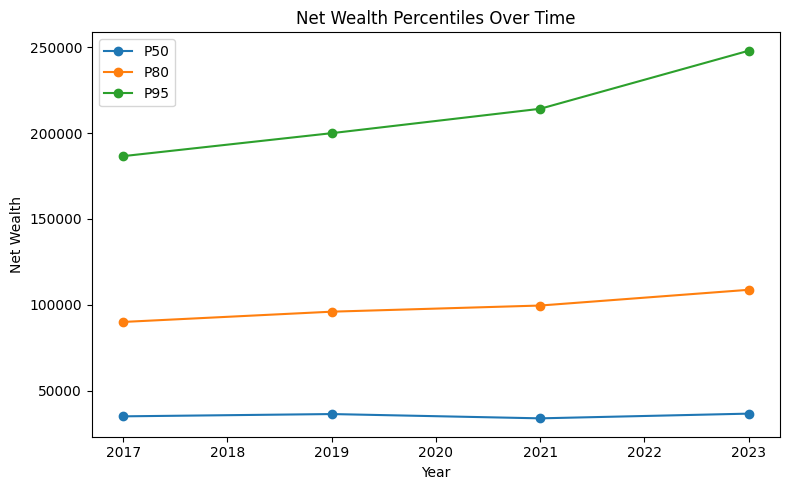

In [51]:
# wealth percentiles
percentiles = [0.5, 0.8, 0.95]

nw_percentiles = (
    df.groupby('year')['net_wealth']
      .quantile(percentiles)
      .unstack(level=1)
      .rename(columns={0.5: 'P50', 0.8: 'P80', 0.95: 'P95'})
      .reset_index()
)

print("\n=== Net Wealth Percentiles by Year ===")
print(nw_percentiles)

plt.figure(figsize=(8, 5))
for col in ['P50', 'P80', 'P95']:
    plt.plot(nw_percentiles['year'], nw_percentiles[col], marker='o', label=col)

plt.xlabel('Year')
plt.ylabel('Net Wealth')
plt.title('Net Wealth Percentiles Over Time')
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
#logistic
from sklearn.preprocessing import  StandardScaler
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)


In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size = 0.2, random_state = 0)

In [54]:
df['high_wealth'].value_counts()

,count
high_wealth,
0,39670
1,9914


In [55]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [56]:
importance = logreg.coef_[0]
pd.DataFrame(importance, index= feature_cols.columns, columns=["Coefficients"])

,Coefficients
year,0.013966
FAMILY INTERVIEW (ID) NUMBER,-0.041141
credit_debt,-8.113592
stocks,4.918380
family_income,15.963547
education,0.016500
net_wealth,5.012348


In [57]:
y_pred = logreg.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [58]:
from sklearn import metrics
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
cf_matrix

array([[7900,   62],
       [ 105, 1850]])

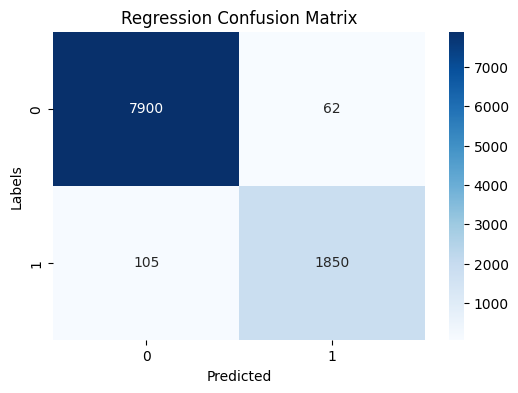

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=[ '0',  '1'])
plt.title("Regression Confusion Matrix")
plt.ylabel("Labels")
plt.xlabel("Predicted")
plt.show()

In [60]:
print("Logistic Regression Test Accuracy:{:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Logistic Regression Train Accuracy:{:.3f}".format(metrics.accuracy_score(y_train, logreg.predict(X_train))))

Logistic Regression Test Accuracy:0.983
Logistic Regression Train Accuracy:0.984


In [61]:
from sklearn.model_selection import cross_val_score
print("Logistic Regression Cross Validation: {:.3f}".format(cross_val_score(logreg, X_train, y_train, cv=10).mean()))


Logistic Regression Cross Validation: 0.984


In [62]:
logreg.predict_proba(X_test)

array([[9.99999922e-01, 7.76198353e-08],
       [9.99998580e-01, 1.42046111e-06],
       [9.99999920e-01, 7.95834963e-08],
       ...,
       [9.99999919e-01, 8.05838781e-08],
       [9.99983899e-01, 1.61009381e-05],
       [9.99988082e-01, 1.19184583e-05]])

In [63]:
y_pred_proba = logreg.predict_proba(X_test)[:,1]

In [64]:
fpr,tpr,thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

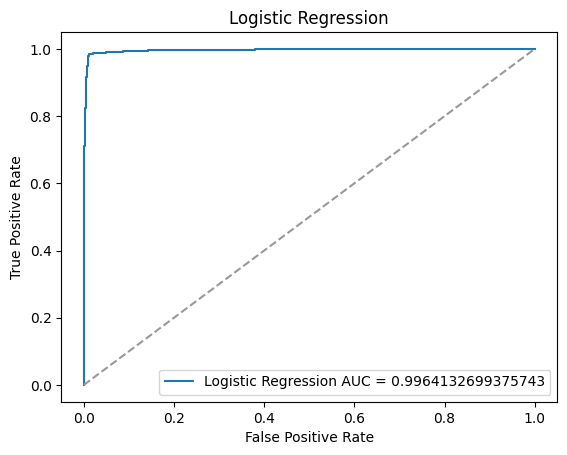

In [65]:
from matplotlib import pyplot
pyplot.plot(fpr, tpr, label = "Logistic Regression AUC = " +str(auc))
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Logistic Regression')
pyplot.legend()
pyplot.plot([0,1],
            [0,1],
            linestyle = '--',
            color = (0.6,0.6,0.6),
            label = "random guessing")

In [67]:
#knn
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)



KNeighborsClassifier()

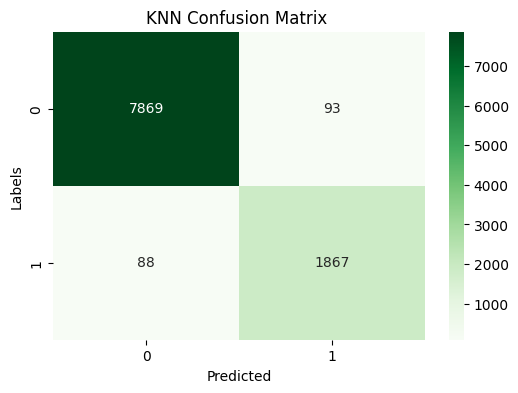

In [68]:
y_pred_knn = knn.predict(X_test)

from sklearn import metrics

cf_matrix_knn = metrics.confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix_knn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title("KNN Confusion Matrix ")
plt.ylabel("Labels")
plt.xlabel("Predicted")
plt.show()



In [69]:
print("KNN Test Accuracy:{:.3f}".format(metrics.accuracy_score(y_test, y_pred_knn)))
print("KNN Train Accuracy:{:.3f}".format(metrics.accuracy_score(y_train, knn.predict(X_train))))




KNN Test Accuracy:0.982
KNN Train Accuracy:0.987


In [70]:
print("KNN Cross Validation: {:.3f}".format(cross_val_score(knn, X_train, y_train, cv=10).mean()))



KNN Cross Validation: 0.981


In [71]:
y_pred_proba_knn = knn.predict_proba(X_test)[:,1]

fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test, y_pred_proba_knn)
auc_knn = metrics.roc_auc_score(y_test, y_pred_proba_knn)



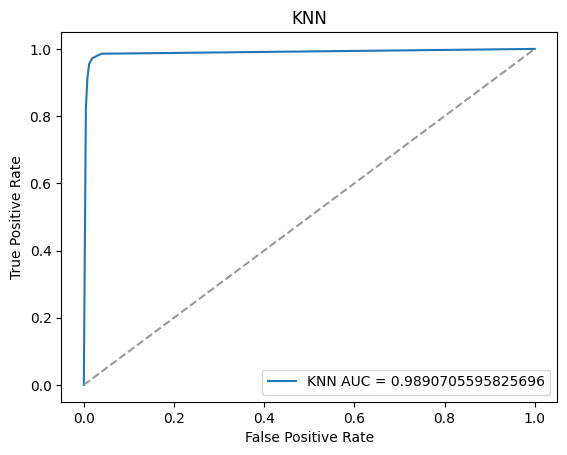

In [72]:
pyplot.plot(fpr_knn, tpr_knn, label = "KNN AUC = " + str(auc_knn))
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('KNN')
pyplot.legend()
pyplot.plot([0,1],[0,1], linestyle='--', color=(0.6,0.6,0.6))

In [73]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=True, random_state=0)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)


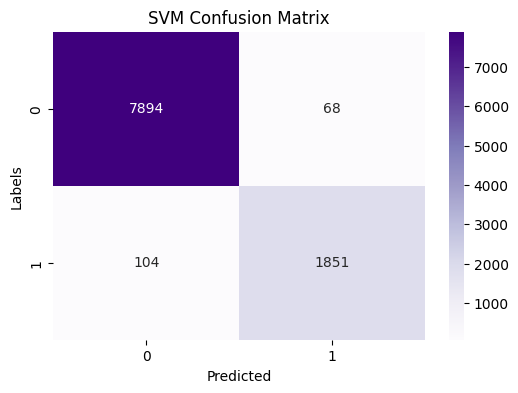

In [74]:
cf_matrix_svm = metrics.confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title("SVM Confusion Matrix")
plt.ylabel("Labels")
plt.xlabel("Predicted")
plt.show()



In [75]:
print("SVM Test Accuracy:{:.3f}".format(metrics.accuracy_score(y_test, y_pred_svm)))
print("SVM Train Accuracy:{:.3f}".format(metrics.accuracy_score(y_train, svm.predict(X_train))))



SVM Test Accuracy:0.983
SVM Train Accuracy:0.984


In [ ]:
print("SVM Cross Validation:", cross_val_score(svm, X_train, y_train, cv=10).mean())



In [ ]:
y_pred_proba_svm = svm.predict_proba(X_test)[:,1]

fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, y_pred_proba_svm)
auc_svm = metrics.roc_auc_score(y_test, y_pred_proba_svm)



In [ ]:
pyplot.plot(fpr_svm, tpr_svm, label = "SVM AUC = " + str(auc_svm))
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('SVM')
pyplot.legend()
pyplot.plot([0,1],
            [0,1],
            linestyle='--',
            color=(0.6,0.6,0.6))

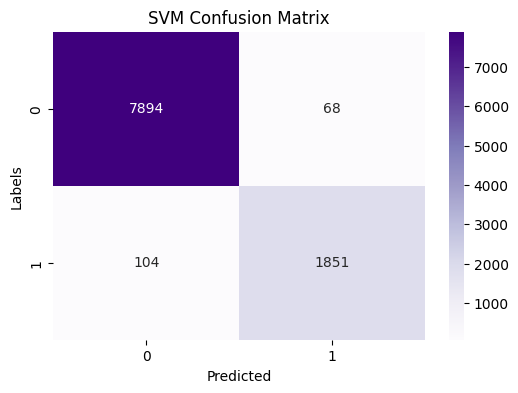

SVM Test Accuracy:0.983
SVM Train Accuracy:0.984
SVM Cross Validation: 0.9837900894685747


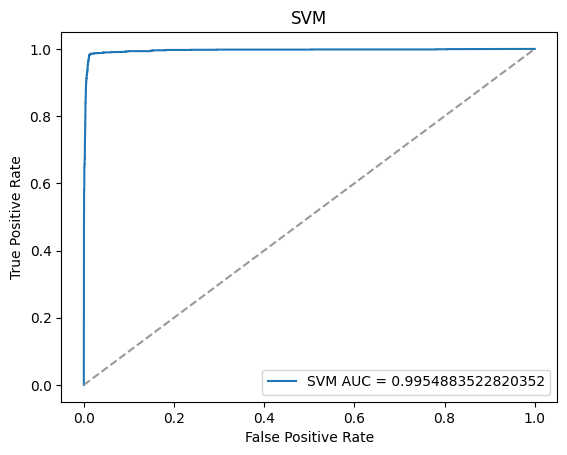